# Loan Approval Classification Dataset

Dataset: https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data/data

In [1]:
!python --version

Python 3.10.16


In [2]:
!pip install tensorflow

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

%matplotlib inline
from math import ceil
from tqdm.auto import tqdm
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dropout, BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import Input, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.data import Dataset
from tensorflow.keras.metrics import AUC
from keras.callbacks import Callback

In [4]:
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

In [5]:
df = pd.read_csv("loan_data.csv")

In [6]:
df.head()

person_age person_gender person_education  person_income  person_emp_exp  \
0        22.0        female           Master        71948.0               0   
1        21.0        female      High School        12282.0               0   
2        25.0        female      High School        12438.0               3   
3        23.0        female         Bachelor        79753.0               0   
4        24.0          male           Master        66135.0               1   

  person_home_ownership  loan_amnt loan_intent  loan_int_rate  \
0                  RENT    35000.0    PERSONAL          16.02   
1                   OWN     1000.0   EDUCATION          11.14   
2              MORTGAGE     5500.0     MEDICAL          12.87   
3                  RENT    35000.0     MEDICAL          15.23   
4                  RENT    35000.0     MEDICAL          14.27   

   loan_percent_income  cb_person_cred_hist_length  credit_score  \
0                 0.49                         3.0           561   
1                 0.08                         2.0           504   
2                 0.44                         3.0           635   
3                 0.44                         2.0           675   
4                 0.53                         4.0           586   

  previous_loan_defaults_on_file  loan_status  
0                             No            1  
1                            Yes            0  
2                             No            1  
3                             No            1  
4                             No            1

In [7]:
df.dtypes

person_age                        float64
person_gender                      object
person_education                   object
person_income                     float64
person_emp_exp                      int64
person_home_ownership              object
loan_amnt                         float64
loan_intent                        object
loan_int_rate                     float64
loan_percent_income               float64
cb_person_cred_hist_length        float64
credit_score                        int64
previous_loan_defaults_on_file     object
loan_status                         int64
dtype: object

In [8]:
df.describe(include="all").T

count unique        top   freq  \
person_age                      45000.0    NaN        NaN    NaN   
person_gender                     45000      2       male  24841   
person_education                  45000      5   Bachelor  13399   
person_income                   45000.0    NaN        NaN    NaN   
person_emp_exp                  45000.0    NaN        NaN    NaN   
person_home_ownership             45000      4       RENT  23443   
loan_amnt                       45000.0    NaN        NaN    NaN   
loan_intent                       45000      6  EDUCATION   9153   
loan_int_rate                   45000.0    NaN        NaN    NaN   
loan_percent_income             45000.0    NaN        NaN    NaN   
cb_person_cred_hist_length      45000.0    NaN        NaN    NaN   
credit_score                    45000.0    NaN        NaN    NaN   
previous_loan_defaults_on_file    45000      2        Yes  22858   
loan_status                     45000.0    NaN        NaN    NaN   

                                        mean           std     min      25%  \
person_age                         27.764178      6.045108    20.0     24.0   
person_gender                            NaN           NaN     NaN      NaN   
person_education                         NaN           NaN     NaN      NaN   
person_income                   80319.053222  80422.498632  8000.0  47204.0   
person_emp_exp                      5.410333      6.063532     0.0      1.0   
person_home_ownership                    NaN           NaN     NaN      NaN   
loan_amnt                        9583.157556   6314.886691   500.0   5000.0   
loan_intent                              NaN           NaN     NaN      NaN   
loan_int_rate                      11.006606      2.978808    5.42     8.59   
loan_percent_income                 0.139725      0.087212     0.0     0.07   
cb_person_cred_hist_length          5.867489      3.879702     2.0      3.0   
credit_score                      632.608756     50.435865   390.0    601.0   
previous_loan_defaults_on_file           NaN           NaN     NaN      NaN   
loan_status                         0.222222      0.415744     0.0      0.0   

                                    50%       75%        max  
person_age                         26.0      30.0      144.0  
person_gender                       NaN       NaN        NaN  
person_education                    NaN       NaN        NaN  
person_income                   67048.0  95789.25  7200766.0  
person_emp_exp                      4.0       8.0      125.0  
person_home_ownership               NaN       NaN        NaN  
loan_amnt                        8000.0  12237.25    35000.0  
loan_intent                         NaN       NaN        NaN  
loan_int_rate                     11.01     12.99       20.0  
loan_percent_income                0.12      0.19       0.66  
cb_person_cred_hist_length          4.0       8.0       30.0  
credit_score                      640.0     670.0      850.0  
previous_loan_defaults_on_file      NaN       NaN        NaN  
loan_status                         0.0       0.0        1.0

## 1. Setting up the validation framework

In [9]:
# Perform the train/validation/test split with Scikit-Learn
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [10]:
len(df_train), len(df_val), len(df_test)

(27000, 9000, 9000)

In [11]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [12]:
y_train = df_train.loan_status.values
y_val = df_val.loan_status.values
y_test = df_test.loan_status.values

del df_train['loan_status']
del df_val['loan_status']
del df_test['loan_status']

In [13]:
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

{0: 21034, 1: 5966}


## 2. Exploratory Data Analysis

In [14]:
df_full_train = df_full_train.reset_index(drop=True)

In [15]:
df_full_train.isnull().sum()

person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64

In [16]:
for col in df_full_train.columns:
    print(col)
    print(df_full_train[col].unique()[:5])
    print(df_full_train[col].nunique())
    print()

person_age
[23. 29. 28. 36. 32.]
60

person_gender
['male' 'female']
2

person_education
['High School' 'Bachelor' 'Associate' 'Master' 'Doctorate']
5

person_income
[ 49296. 116474.  27732. 122428.  81261.]
28526

person_emp_exp
[ 0  3  7 17  5]
62

person_home_ownership
['RENT' 'OWN' 'MORTGAGE' 'OTHER']
4

loan_amnt
[10000.  6400.  2500. 12000.  9000.]
3752

loan_intent
['MEDICAL' 'HOMEIMPROVEMENT' 'PERSONAL' 'VENTURE' 'EDUCATION']
6

loan_int_rate
[11.01 11.49  5.79  8.94 12.21]
1273

loan_percent_income
[0.2  0.05 0.09 0.1  0.11]
62

cb_person_cred_hist_length
[ 2.  8.  5. 11.  7.]
29

credit_score
[601 651 692 694 670]
338

previous_loan_defaults_on_file
['Yes' 'No']
2

loan_status
[0 1]
2



#### Exploring the target variable

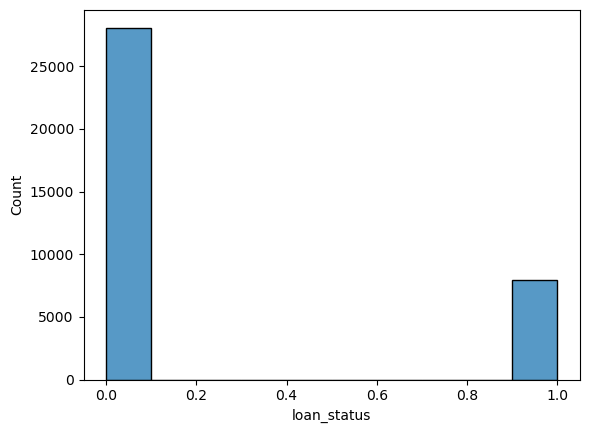

In [17]:
sns.histplot(df_full_train.loan_status, bins=10)
plt.show()

In [18]:
df.duplicated().sum()

0

#### The age of the people with age more than 100 years and exmployment age of higher than 70 years are replaced with modes.

In [19]:
df_full_train[df_full_train.person_age>100]

person_age person_gender person_education  person_income  \
3709        144.0          male        Associate       241424.0   
12759       144.0          male         Bachelor       300616.0   
16562       123.0          male         Bachelor        94723.0   
19209       123.0        female      High School        97140.0   
20300       144.0        female        Associate      7200766.0   
23259       109.0          male      High School      5556399.0   
33636       116.0          male         Bachelor      5545545.0   

       person_emp_exp person_home_ownership  loan_amnt loan_intent  \
3709              121              MORTGAGE     6000.0   EDUCATION   
12759             125                  RENT     4800.0     VENTURE   
16562             100                  RENT    20000.0     VENTURE   
19209             101                  RENT    20400.0   EDUCATION   
20300             124              MORTGAGE     5000.0    PERSONAL   
23259              85              MORTGAGE     6195.0     VENTURE   
33636              93              MORTGAGE     3823.0     VENTURE   

       loan_int_rate  loan_percent_income  cb_person_cred_hist_length  \
3709           11.86                 0.02                         2.0   
12759          13.57                 0.02                         3.0   
16562          11.01                 0.21                         4.0   
19209          10.25                 0.21                         3.0   
20300          12.73                 0.00                        25.0   
23259          12.58                 0.00                        22.0   
33636          12.15                 0.00                        24.0   

       credit_score previous_loan_defaults_on_file  loan_status  
3709            807                             No            0  
12759           789                             No            0  
16562           714                            Yes            0  
19209           805                            Yes            0  
20300           850                             No            0  
23259           792                             No            0  
33636           708                             No            0

In [20]:
df_full_train.person_age= np.where(df_full_train.person_age>100, df_full_train.person_age.mode().iloc[0], df_full_train.person_age)

In [21]:
df_full_train.person_age.max()

94.0

In [22]:
df_full_train.person_emp_exp= np.where(df_full_train.person_emp_exp>70, df_full_train.person_emp_exp.mode().iloc[0], df_full_train.person_emp_exp)

In [23]:
df_full_train.person_emp_exp.max()

62

#### Checking the same for the test data

In [24]:
df_test.person_age>100

0       False
1       False
2       False
3       False
4       False
        ...  
8995    False
8996    False
8997    False
8998    False
8999    False
Name: person_age, Length: 9000, dtype: bool

In [25]:
df_test.person_emp_exp>100

0       False
1       False
2       False
3       False
4       False
        ...  
8995    False
8996    False
8997    False
8998    False
8999    False
Name: person_emp_exp, Length: 9000, dtype: bool

#### Dividing the variables to categorical and numerical

In [26]:
categorical = list(df_full_train.dtypes[df_full_train.dtypes == 'object'].index)
categorical

['person_gender',
 'person_education',
 'person_home_ownership',
 'loan_intent',
 'previous_loan_defaults_on_file']

In [27]:
numerical = list(df_full_train.dtypes[(df_full_train.dtypes == 'int64') | (df_full_train.dtypes == 'float64')].index)
numerical.remove("loan_status")
numerical

['person_age',
 'person_income',
 'person_emp_exp',
 'loan_amnt',
 'loan_int_rate',
 'loan_percent_income',
 'cb_person_cred_hist_length',
 'credit_score']

#### All Numeric Variables' Violin Plots in one figure

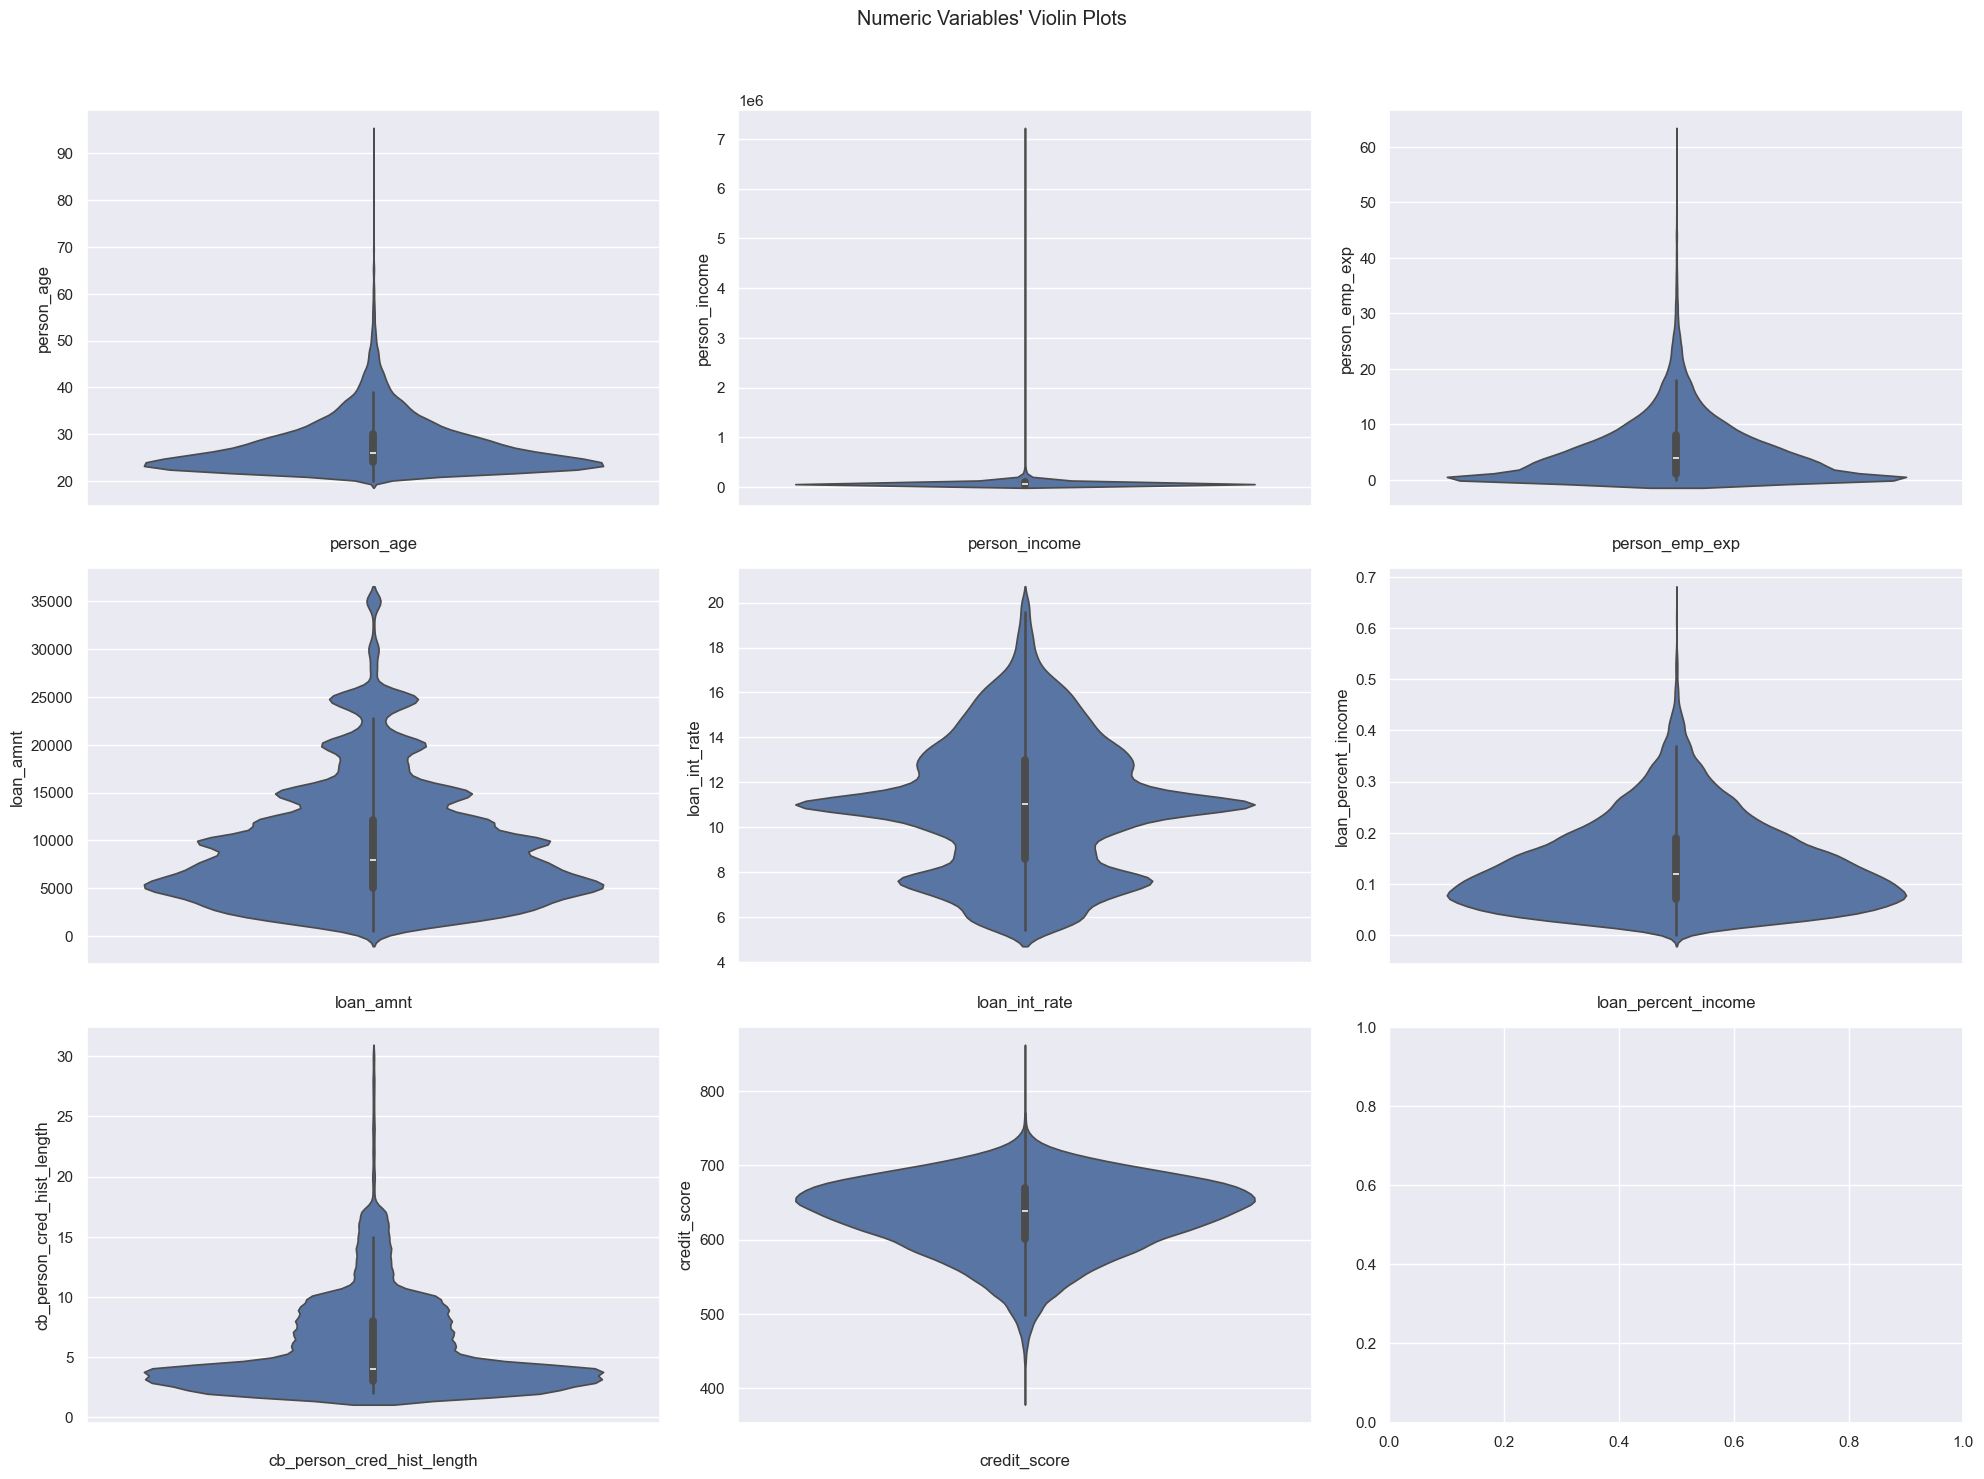

In [136]:
sns.set()

# Prepare figure. Create individual axes where each violin plot will be placed
fig, axes = plt.subplots(3, ceil(len(numerical) / 3), figsize=(20, 15))

# Plot data
# Iterate across axes objects and associate each violin plot
for ax, feat in zip(axes.flatten(), numerical):  # Notice the zip() function and flatten() method
    sns.violinplot(ax=ax, y=df_full_train[feat])  # Use sns.violinplot to create a violin plot for each numeric feature
    ax.set_title(feat, y=-0.13)

# Layout
# Add a centered title to the figure
title = "Numeric Variables' Violin Plots"
plt.suptitle(title)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title

plt.show()


#### All Numeric Variables' Box Plots in one figure

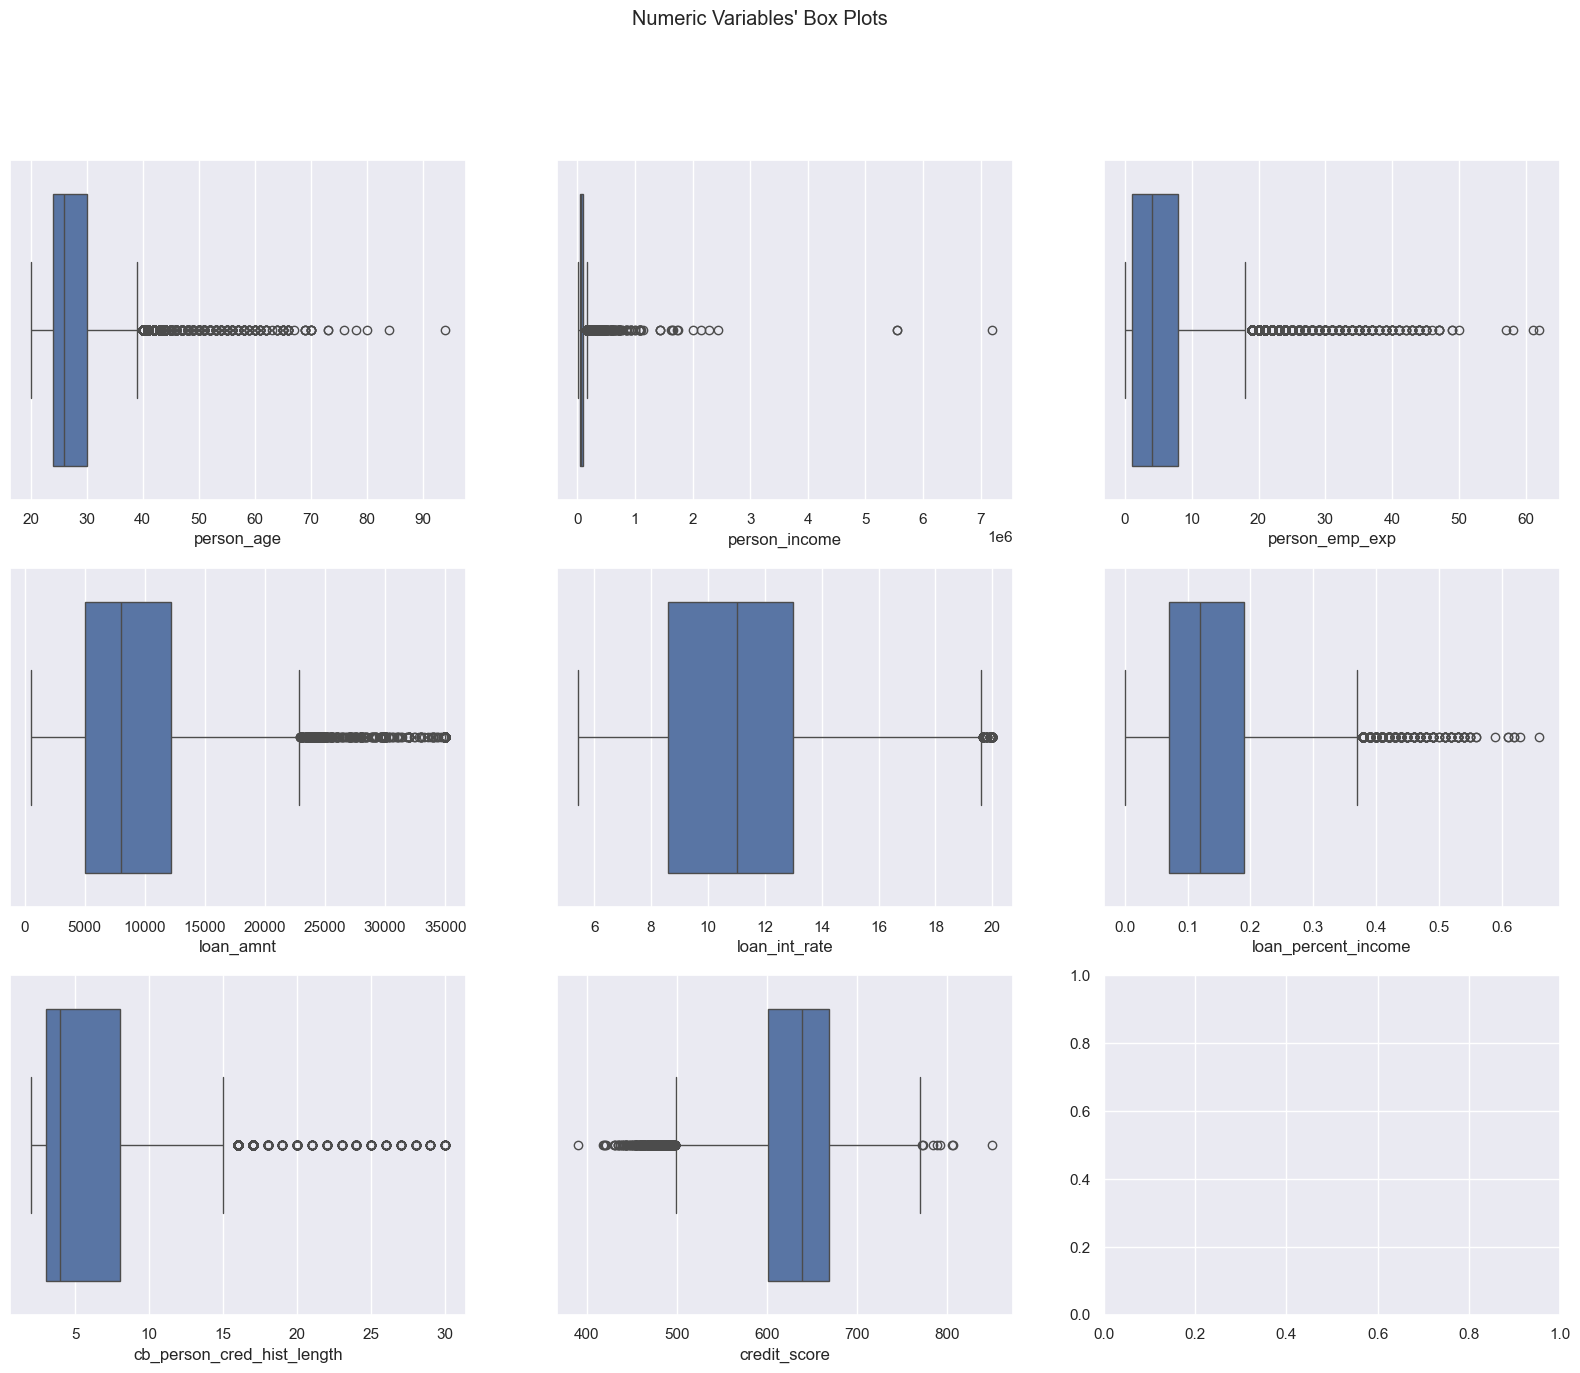

In [137]:
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(3, ceil(len(numerical) / 3), figsize=(20, 15))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), numerical): # Notice the zip() function and flatten() method
    sns.boxplot(x=df_full_train[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"

plt.suptitle(title)

plt.show()

#### All Numeric Variables' Histograms in one figure

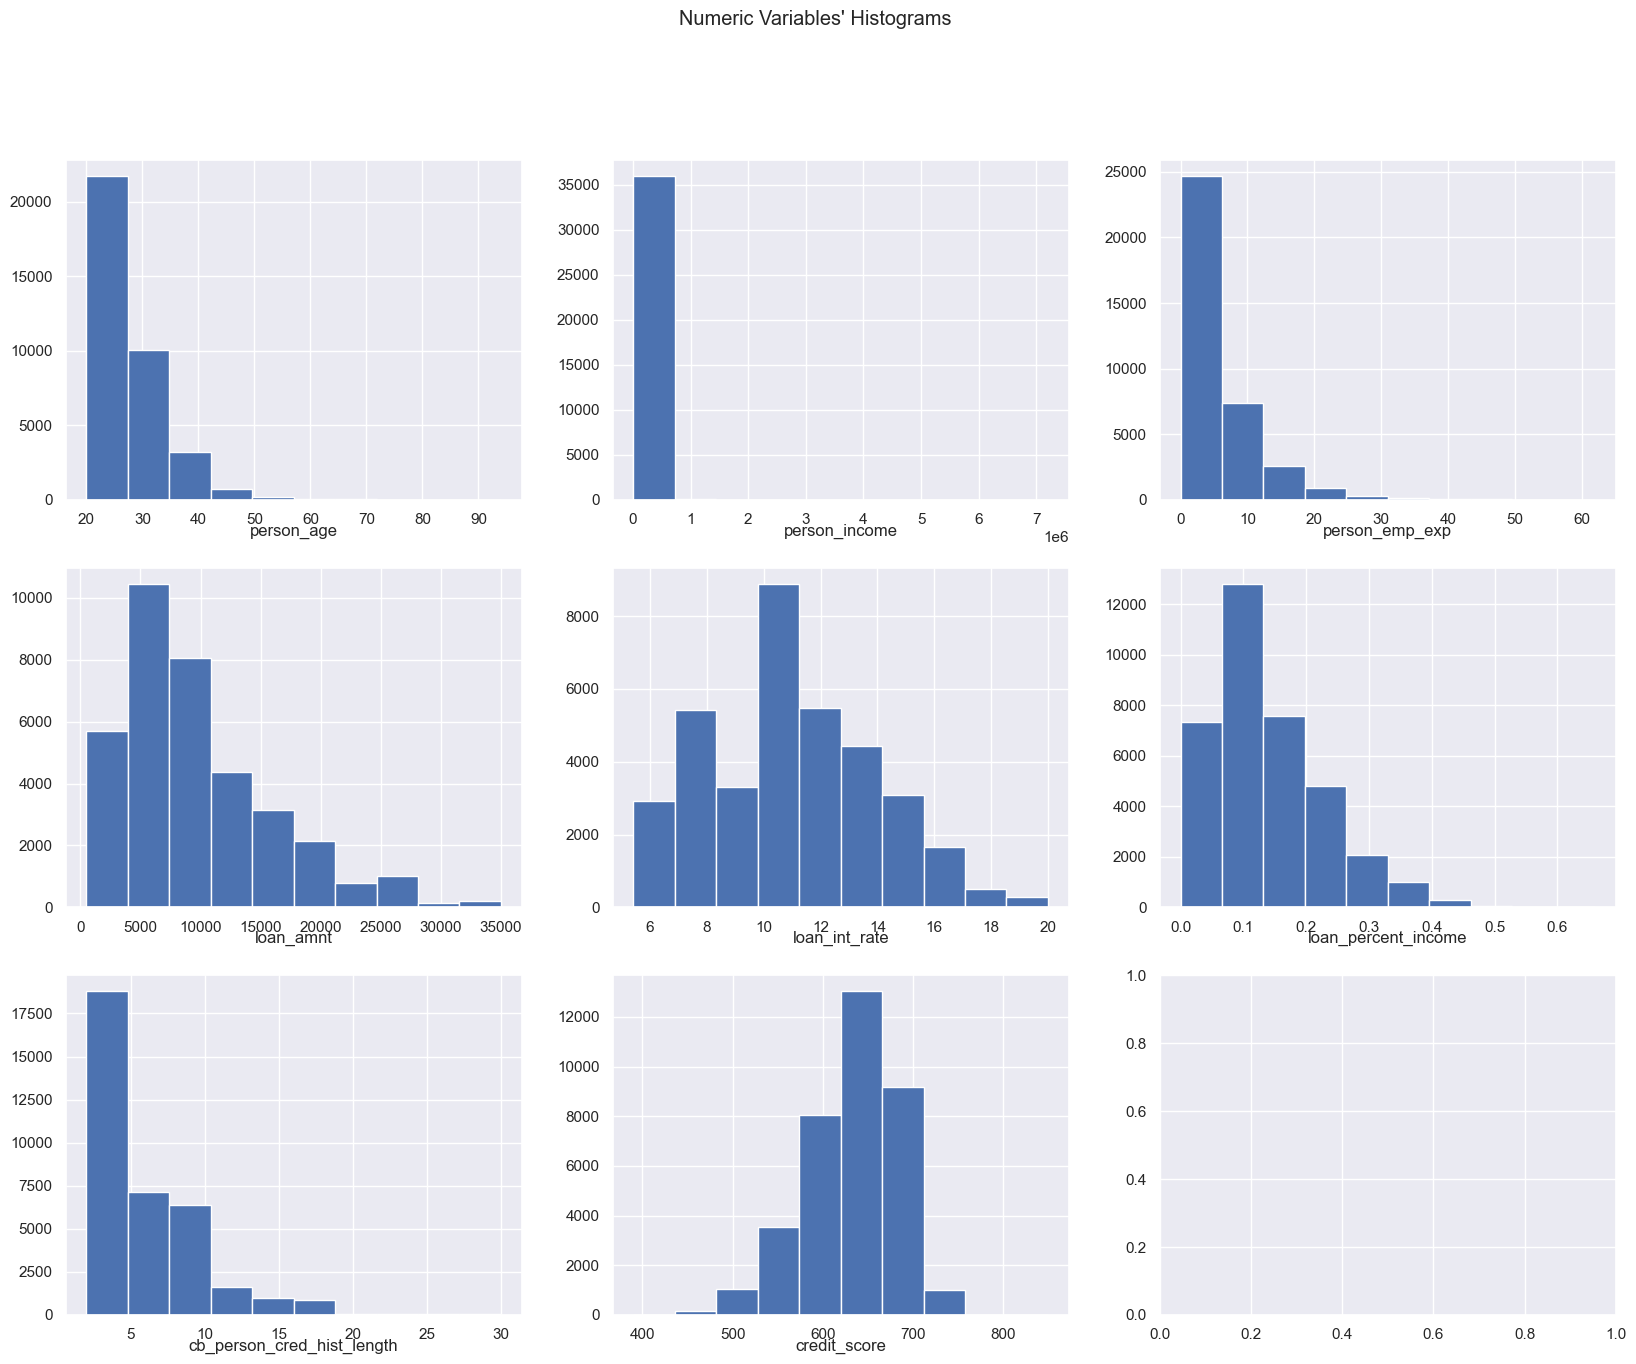

In [138]:
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(3, ceil(len(numerical) / 3), figsize=(20, 15))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), numerical): # Notice the zip() function and flatten() method
    ax.hist(df_full_train[feat])
    ax.set_title(feat, y=-0.13)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Histograms"

plt.suptitle(title)

plt.show()

#### The distribution of person age in relation to loan status

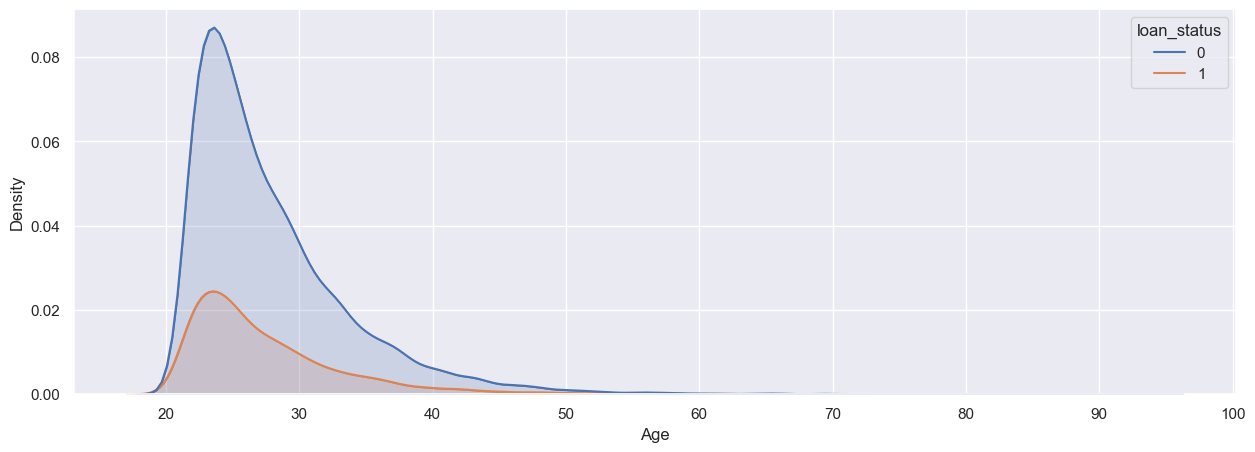

In [139]:
plt.figure(figsize=(15, 5))
sns.kdeplot(df_full_train, x="person_age", hue="loan_status", fill=True, alpha=.2)
sns.kdeplot(df_full_train, x="person_age", hue="loan_status")
plt.xlabel("Age")
plt.show()

#### Personal income and employment experience in relation to loan status

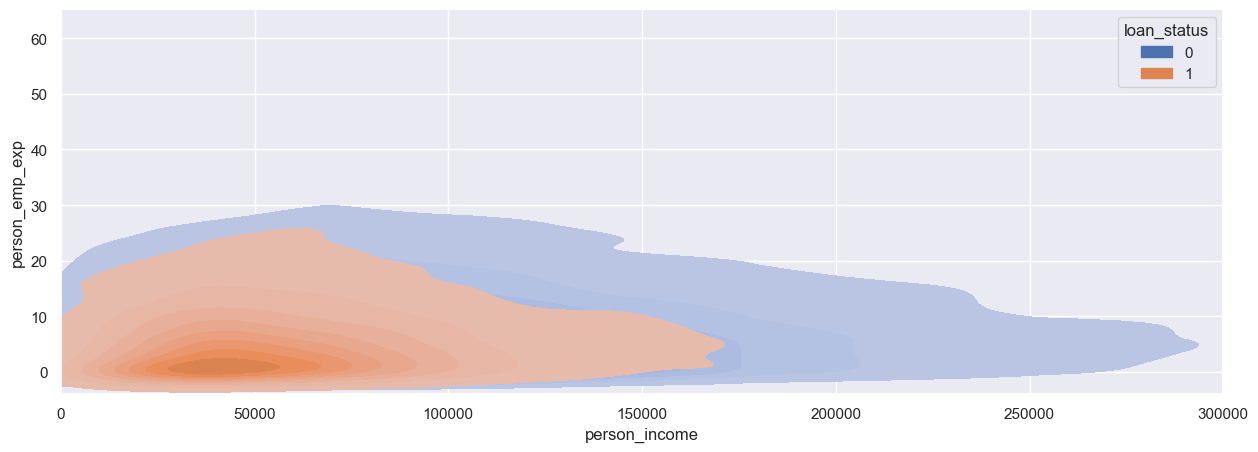

In [140]:
plt.figure(figsize=(15, 5))
sns.kdeplot(df_full_train, x="person_income", y="person_emp_exp", hue="loan_status", fill=True)
plt.xlabel("person_income")
plt.ylabel("person_emp_exp")
plt.xlim(0, 300000)
plt.show()

#### All Non-Metric Variables' Absolute Frequencies

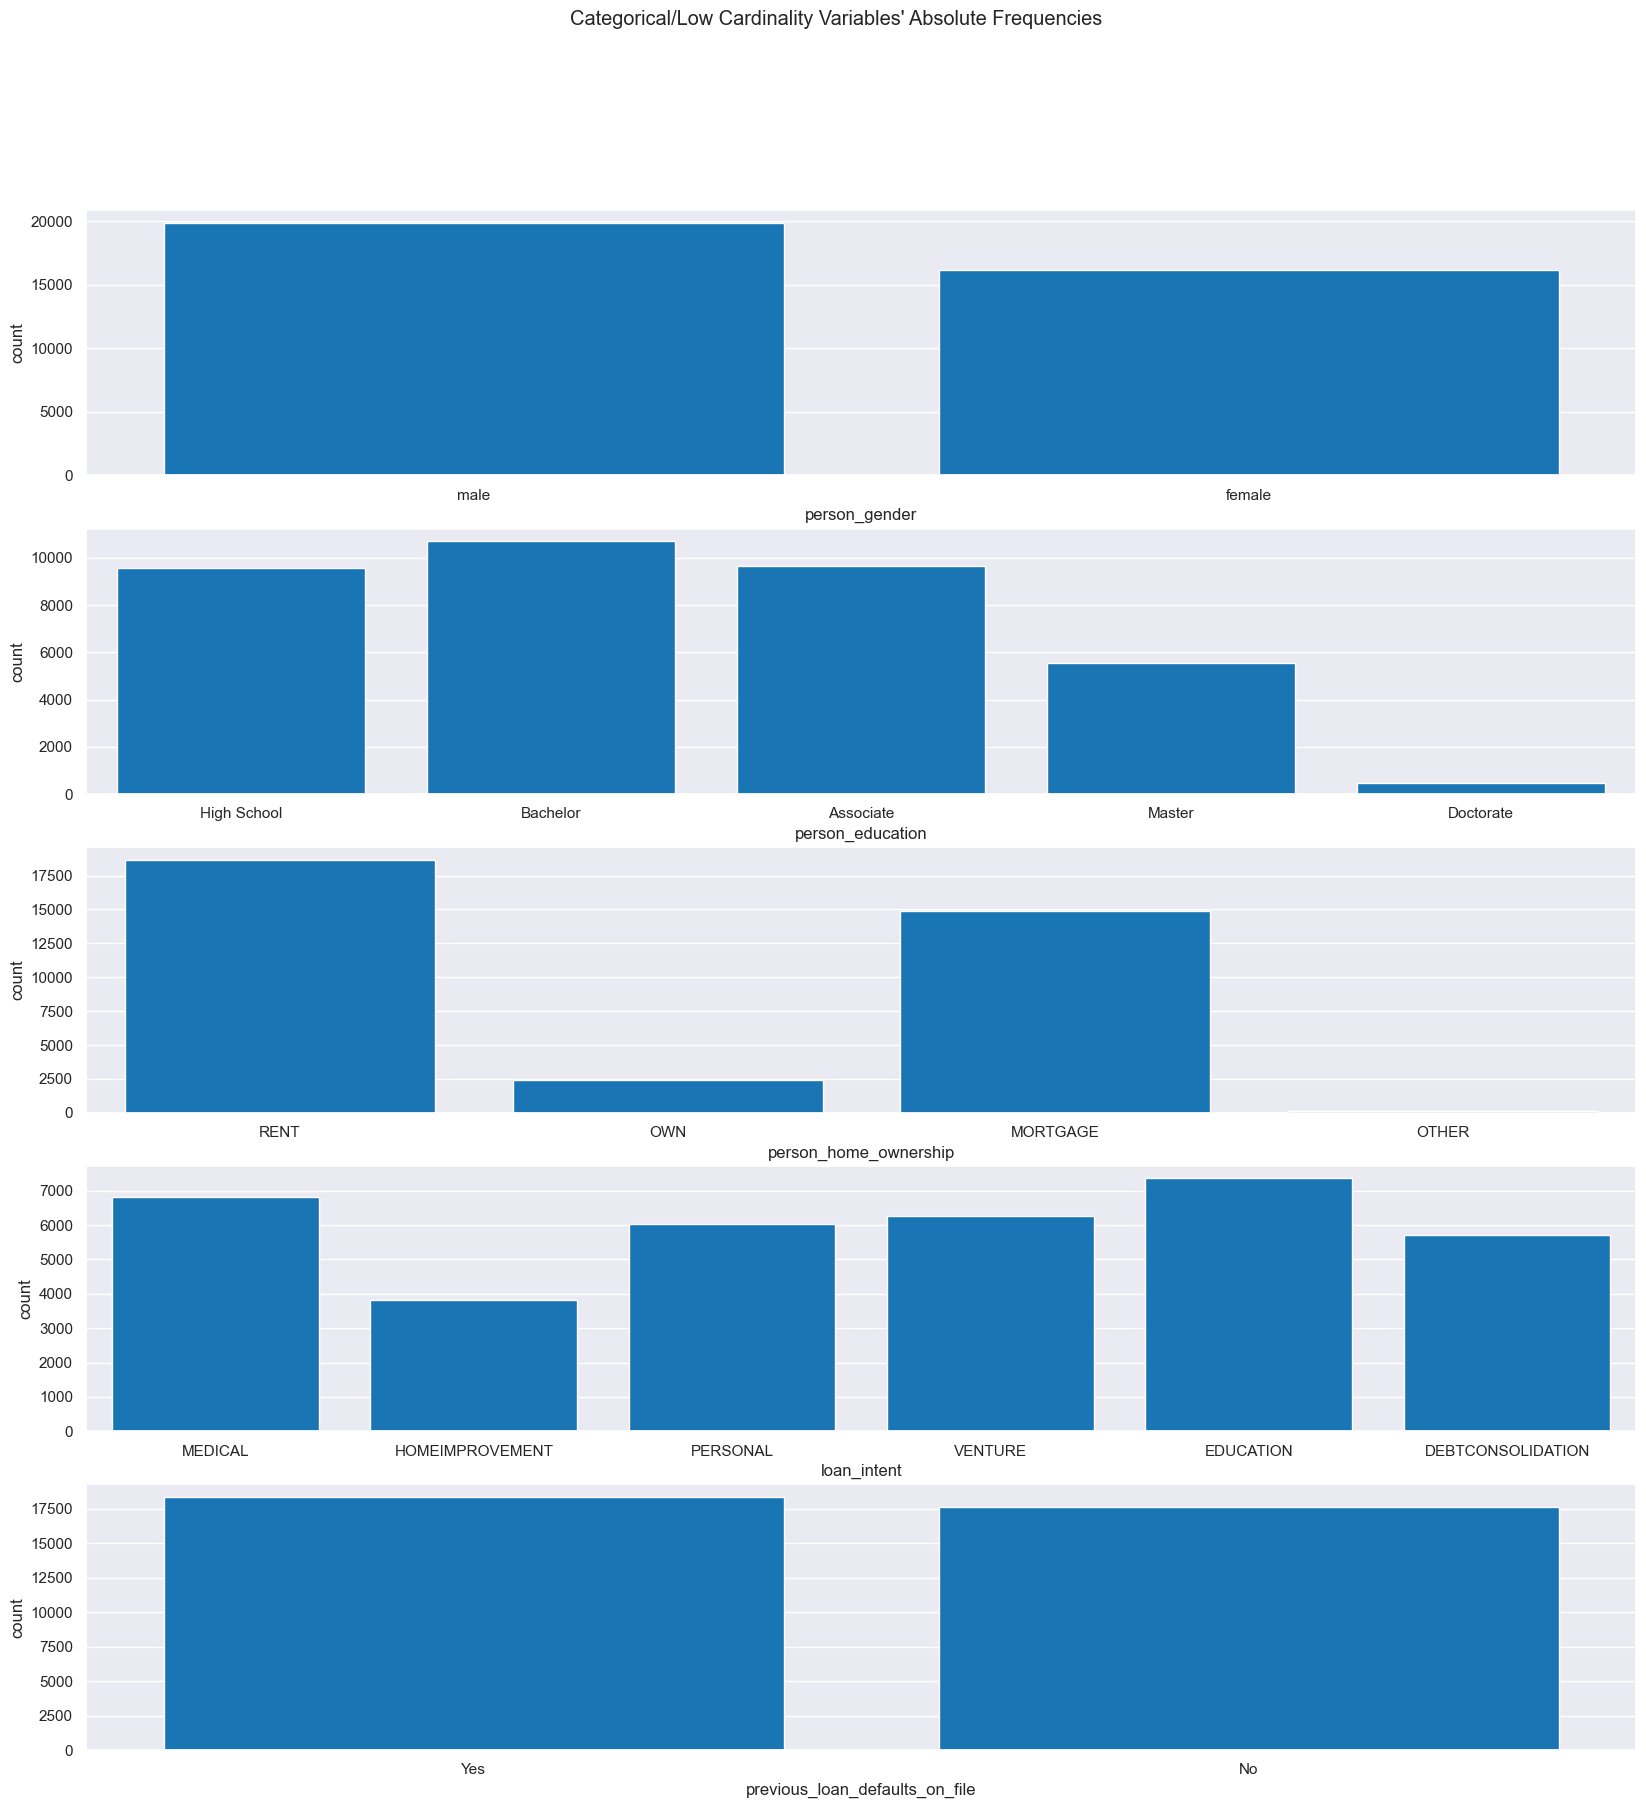

In [141]:
sns.set()

# Prepare figure. Create individual axes where each bar plot will be placed
fig, axes = plt.subplots(5, ceil(len(categorical) / 5), figsize=(20, 20))

# Plot data
# Iterate across axes objects and associate each bar plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), categorical): # Notice the zip() function and flatten() method
    sns.countplot(x = df_full_train[feat].astype(object), ax=ax, color='#007acc')

title = "Categorical/Low Cardinality Variables' Absolute Frequencies"
plt.suptitle(title)

plt.show()

#### Comparing each categorical variable with the target "loan_status"

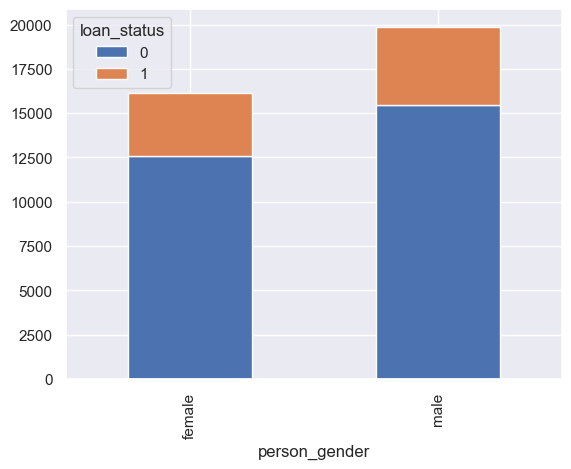

In [142]:
sns.set()
df_counts = df_full_train\
    .groupby(['person_gender', 'loan_status'])\
    .size()\
    .unstack()\
    .plot.bar(stacked=True)
plt.show()

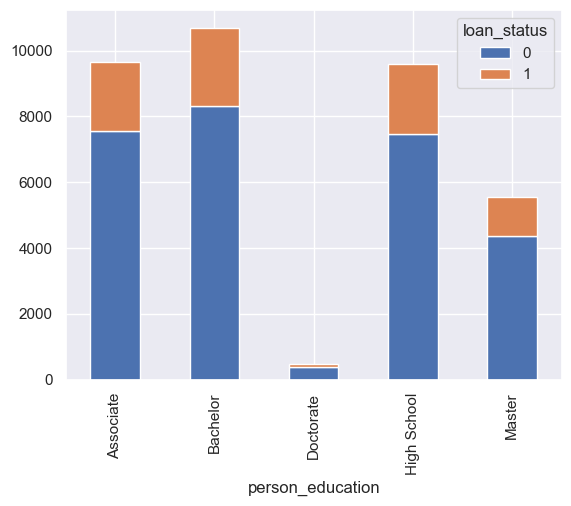

In [143]:
sns.set()
df_counts = df_full_train\
    .groupby(['person_education', 'loan_status'])\
    .size()\
    .unstack()\
    .plot.bar(stacked=True)
plt.show()

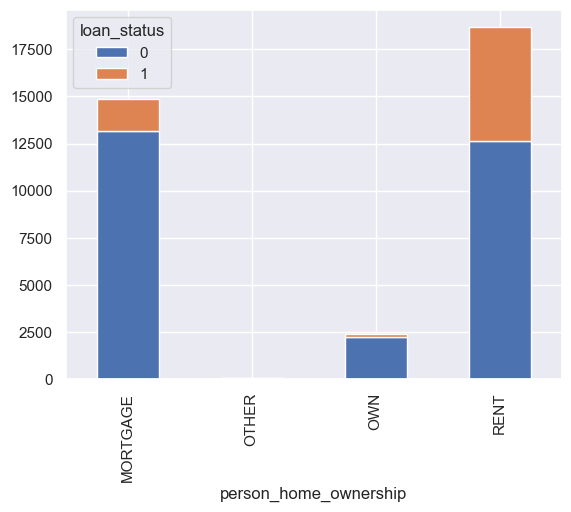

In [144]:
sns.set()
df_counts = df_full_train\
    .groupby(['person_home_ownership', 'loan_status'])\
    .size()\
    .unstack()\
    .plot.bar(stacked=True)
plt.show()

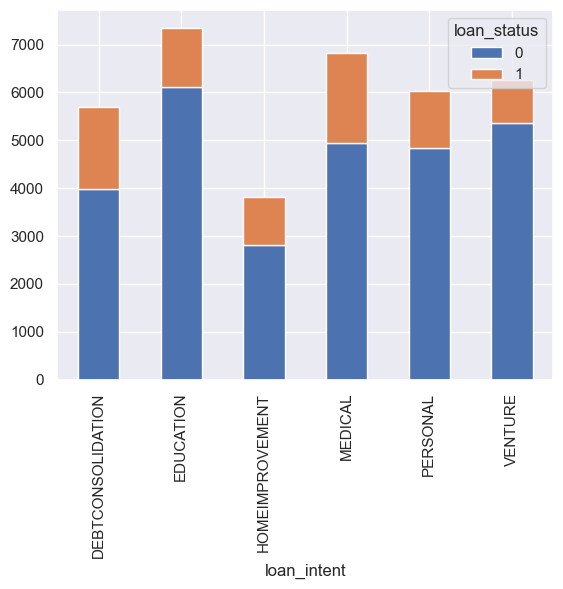

In [145]:
sns.set()
df_counts = df_full_train\
    .groupby(['loan_intent', 'loan_status'])\
    .size()\
    .unstack()\
    .plot.bar(stacked=True)
plt.show()

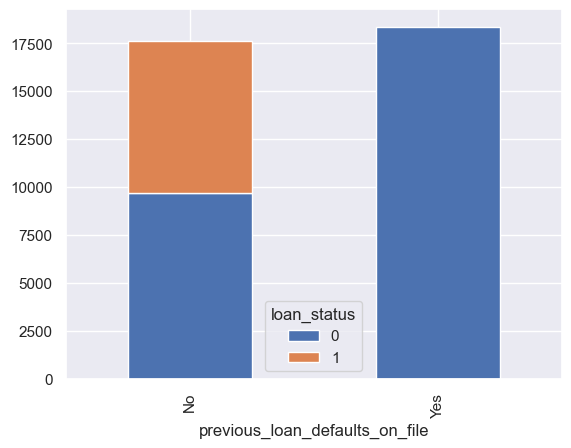

In [146]:
sns.set()
df_counts = df_full_train\
    .groupby(['previous_loan_defaults_on_file', 'loan_status'])\
    .size()\
    .unstack()\
    .plot.bar(stacked=True)
plt.show()

#### Pairwise Relationship of Numerical Variables

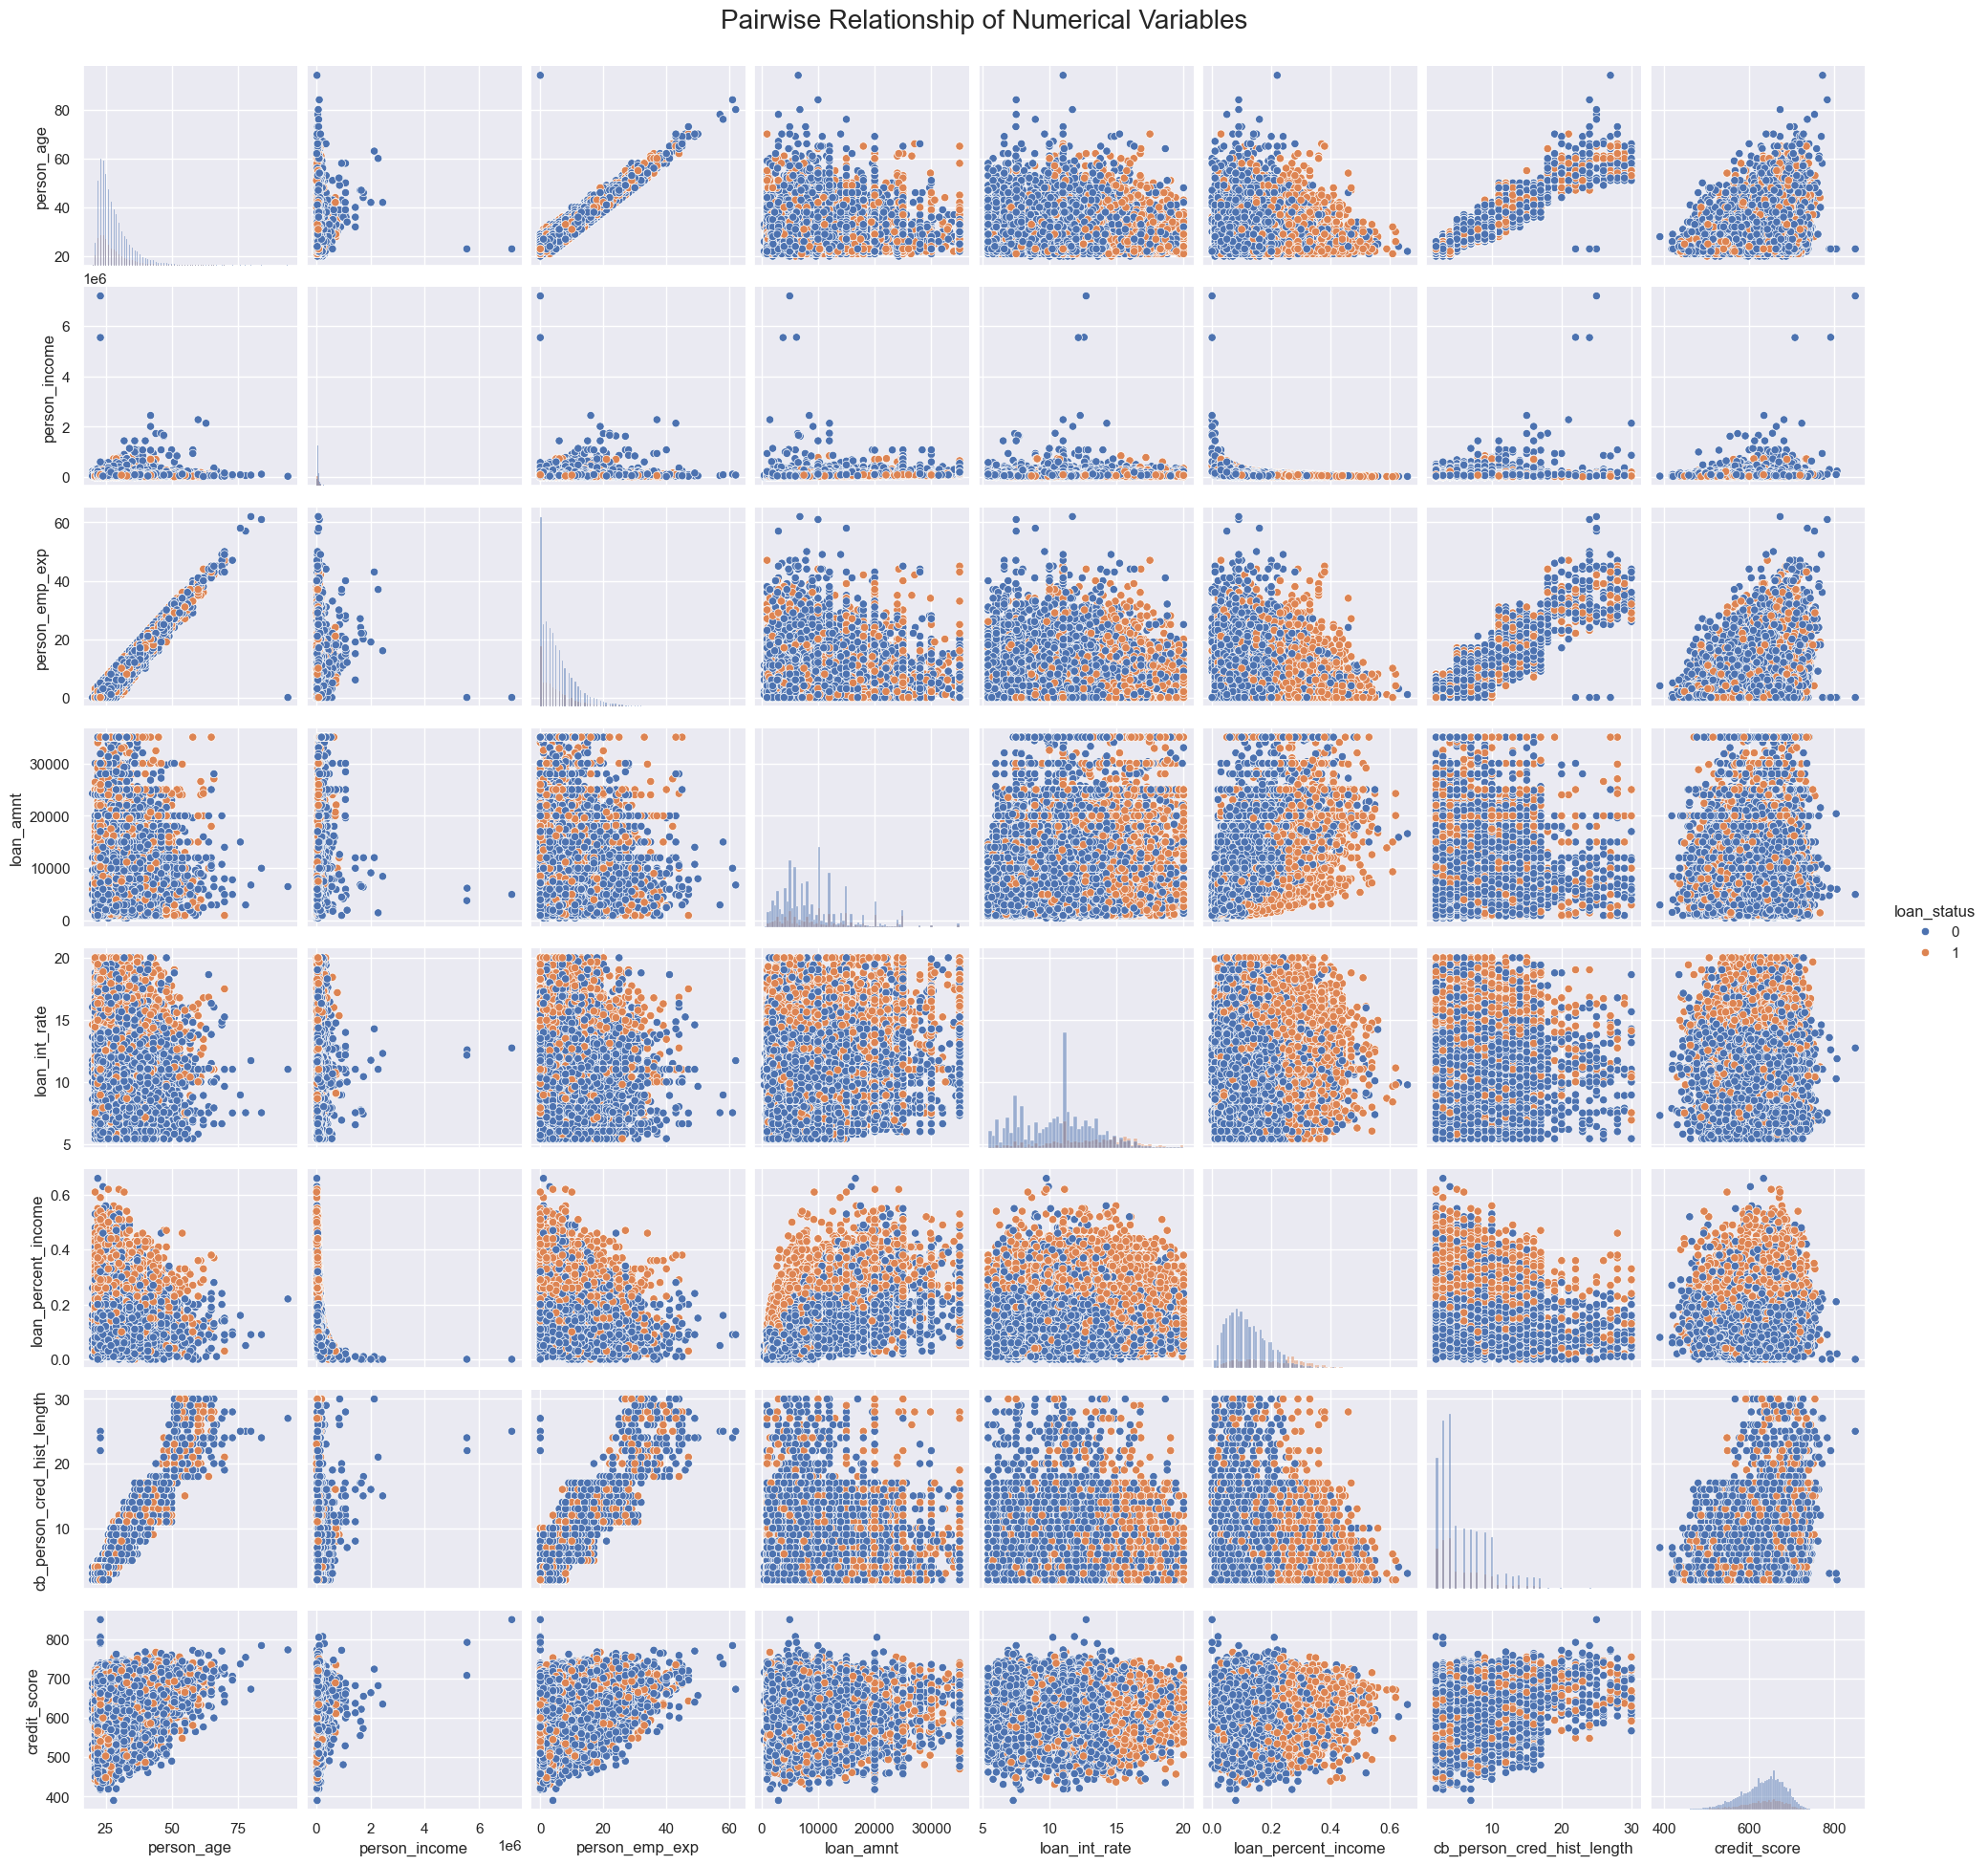

In [147]:
sns.set()

# Setting pairplot
sns.pairplot(df_full_train[numerical + ['loan_status']], diag_kind="hist", hue='loan_status')

# Layout
plt.subplots_adjust(top=0.95)
plt.suptitle("Pairwise Relationship of Numerical Variables", fontsize=20)

plt.show()

# 2. Feature importance: Loan ratio and Mutual information

#### Loan ratio

In [148]:
global_loan_ratio = df_full_train.loan_status.mean()
global_loan_ratio

0.22005555555555556

In [149]:
from IPython.display import display
for c in categorical:
    print(c)
    df_group = df_full_train.groupby(c).loan_status.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_loan_ratio
    df_group['loan'] = df_group['mean'] / global_loan_ratio
    display(df_group)
    print()
    print()

person_gender


mean  count      diff      loan
person_gender                                     
female         0.218612  16129 -0.001443  0.993442
male           0.221227  19871  0.001171  1.005323



person_education


mean  count      diff      loan
person_education                                     
Associate         0.217256   9666 -0.002799  0.987280
Bachelor          0.222015  10702  0.001959  1.008902
Doctorate         0.226994    489  0.006938  1.031530
High School       0.222373   9583  0.002317  1.010531
Master            0.216547   5560 -0.003509  0.984055



person_home_ownership


mean  count      diff      loan
person_home_ownership                                     
MORTGAGE               0.115473  14852 -0.104583  0.524743
OTHER                  0.301075     93  0.081020  1.368178
OWN                    0.073099   2394 -0.146956  0.332186
RENT                   0.321741  18661  0.101685  1.462088



loan_intent


mean  count      diff      loan
loan_intent                                           
DEBTCONSOLIDATION  0.301017   5704  0.080961  1.367913
EDUCATION          0.167777   7355 -0.052279  0.762430
HOMEIMPROVEMENT    0.263598   3824  0.043543  1.197872
MEDICAL            0.274886   6821  0.054831  1.249168
PERSONAL           0.196583   6028 -0.023473  0.893332
VENTURE            0.144065   6268 -0.075990  0.654676



previous_loan_defaults_on_file


mean  count      diff      loan
previous_loan_defaults_on_file                                     
No                              0.449042  17642  0.228987  2.040585
Yes                             0.000000  18358 -0.220056  0.000000

#### Mutual information

In [150]:
def mutual_info_loan_status(series):
    return mutual_info_score(series, df_full_train.loan_status)

In [151]:
mi = df_full_train[categorical].apply(mutual_info_loan_status)
mi = mi.sort_values(ascending=False)

# Format numbers to 5 decimal places
mi = mi.apply(lambda x: f"{x:.5f}")
print(mi)

previous_loan_defaults_on_file    0.18985
person_home_ownership             0.03477
loan_intent                       0.01018
person_education                  0.00002
person_gender                     0.00000
dtype: object


#### Correlation

In [152]:
def cor_heatmap(cor):
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.2')
    plt.figure(figsize=(5,5))
    plt.show()

In [153]:
# Correlation with Pearson method
cor_pearson = df_full_train[numerical].corr(method ='pearson')

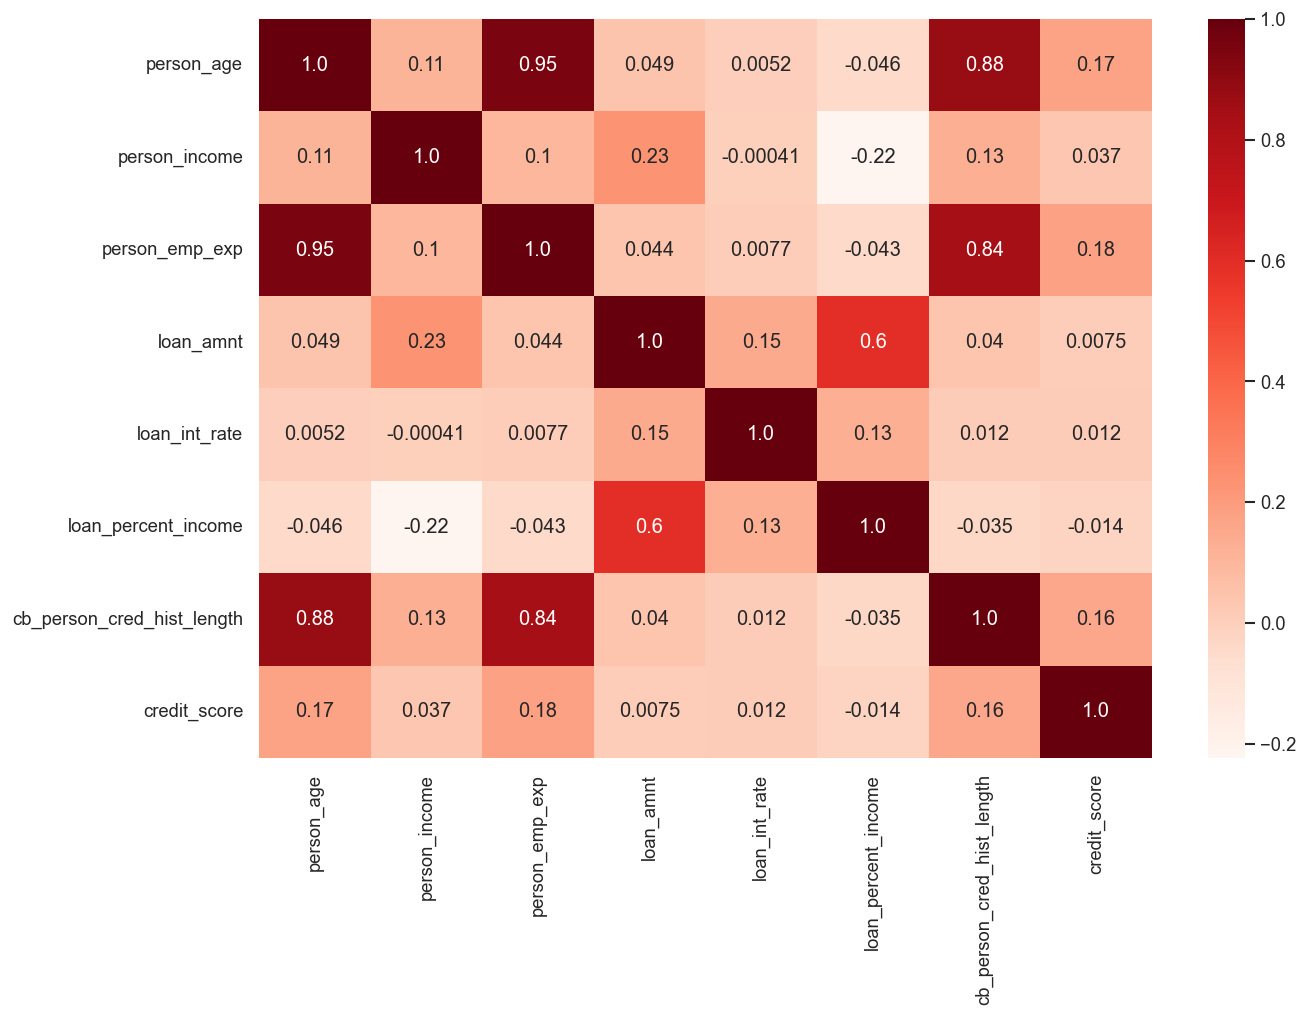

<Figure size 500x500 with 0 Axes>

In [154]:
# Spearman correlation heatmap
fig = plt.figure(figsize=(12,8), dpi = 120)
cor_heatmap(cor_pearson)

## 4. Standartization

In [28]:
scaler = StandardScaler()
#scaler = MinMaxScaler()

# Fit and transform
X_train_scaled = scaler.fit_transform(df_train[numerical])

# Convert the result to pandas DataFrame
X_train_numerical = pd.DataFrame(X_train_scaled, columns=numerical)

# Do the same for X_val and X_test
X_val_scaled = scaler.transform(df_val[numerical])
X_val_numerical = pd.DataFrame(X_val_scaled, columns=numerical)

X_test_scaled = scaler.transform(df_test[numerical])
X_test_numerical = pd.DataFrame(X_test_scaled, columns=numerical)

## 5. One-hot encoding

In [29]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

In [30]:
X_train_categorical = ohe.fit_transform(df_train[categorical].values)

In [31]:
ohe.get_feature_names_out()

array(['x0_female', 'x0_male', 'x1_Associate', 'x1_Bachelor',
       'x1_Doctorate', 'x1_High School', 'x1_Master', 'x2_MORTGAGE',
       'x2_OTHER', 'x2_OWN', 'x2_RENT', 'x3_DEBTCONSOLIDATION',
       'x3_EDUCATION', 'x3_HOMEIMPROVEMENT', 'x3_MEDICAL', 'x3_PERSONAL',
       'x3_VENTURE', 'x4_No', 'x4_Yes'], dtype=object)

In [32]:
# Combining two matrices into one - `X_train`
X_train = np.column_stack([X_train_numerical, X_train_categorical])

In [33]:
# Doing the same preprocessing for X_val and X_test
X_val_categorical = ohe.fit_transform(df_val[categorical].values)
X_val = np.column_stack([X_val_numerical, X_val_categorical])

X_test_categorical = ohe.fit_transform(df_test[categorical].values)
X_test = np.column_stack([X_test_numerical, X_test_categorical])

## 5. Logistic Regression

In [38]:
parameters = {"max_iter":[1000, 1500, 2000],
              "C":[20, 15, 10],
              "solver":["lbfgs", "newton-cg", "saga"]}

lr = LogisticRegression(random_state=seed_value)

# Use f1_score as the scoring metric
gs_lr = GridSearchCV(lr, param_grid=parameters, n_jobs=-1, cv=5, scoring="f1")
gs_lr.fit(X_train, y_train)

# Retrieve the best F1 score and best parameters
best_f1_score = gs_lr.best_score_
best_params = gs_lr.best_params_

print("Best F1 score:", best_f1_score)
print("Best parameters:", best_params)

Best F1 score: 0.7686614695956575
Best parameters: {'C': 20, 'max_iter': 1000, 'solver': 'lbfgs'}


In [39]:
lr = LogisticRegression(random_state=seed_value,
    max_iter=best_params['max_iter'],
    C=best_params['C'],
    solver=best_params['solver']
)

In [42]:
# Predict class labels for the validation set
y_pred_val_lr = gs_lr.predict(X_val)
f1 = f1_score(y_val, y_pred_val_lr, average='weighted')
print("F1 score:", f1)

F1 score: 0.8937245329306444


## 6. Decision Tree

In [43]:
parameters = {"criterion":["gini", "entropy", "log_loss"],
              "max_depth":[5, 6, 7, 8, 9],
              "max_leaf_nodes":[30, 40, 50, 60],
              "min_samples_split":[30, 40],
              }

dt = DecisionTreeClassifier(random_state=seed_value)
gs_dt = GridSearchCV(dt, param_grid=parameters, n_jobs=-1, cv=5, scoring="f1")
gs_dt.fit(X_train, y_train)

# Retrieve the best F1 score and best parameters
best_f1_score = gs_dt.best_score_
best_params = gs_dt.best_params_

print("Best F1 score:", best_f1_score)
print("Best parameters:", best_params)

Best F1 score: 0.8014340739112576
Best parameters: {'criterion': 'gini', 'max_depth': 9, 'max_leaf_nodes': 60, 'min_samples_split': 30}


In [44]:
dt = DecisionTreeClassifier(random_state=seed_value,
                           criterion = best_params['criterion'],
                           max_depth = best_params['max_depth'],
                           max_leaf_nodes = best_params['max_leaf_nodes'],
                           min_samples_split = best_params['min_samples_split'])

In [45]:
# Predict class labels for the validation set
y_pred_val_dt = gs_dt.predict(X_val)
f1 = f1_score(y_val, y_pred_val_dt, average='weighted')
print("F1 score:", f1)

F1 score: 0.9155925704459126


## 7. Random Forest

In [46]:
parameters = {"criterion":["gini", "entropy", "log_loss"],
              "n_estimators":[100, 200, 300, 400],
              "max_depth":[5, 6, 7, 8, 9],
              }

rf = RandomForestClassifier(random_state=seed_value)
gs_rf = GridSearchCV(rf, param_grid=parameters, n_jobs=-1, cv=5, scoring="f1")
gs_rf.fit(X_train, y_train)

# Retrieve the best F1 score and best parameters
best_f1_score = gs_rf.best_score_
best_params = gs_rf.best_params_

print("Best F1 score:", best_f1_score)
print("Best parameters:", best_params)

Best F1 score: 0.8077605194061188
Best parameters: {'criterion': 'gini', 'max_depth': 9, 'n_estimators': 300}


In [47]:
rf = RandomForestClassifier(random_state=seed_value,
                           criterion = best_params['criterion'],
                           n_estimators = best_params['n_estimators'],
                           max_depth = best_params['max_depth'])

In [48]:
# Predict class labels for the validation set
y_pred_val_rf = gs_rf.predict(X_val)
f1 = f1_score(y_val, y_pred_val_rf, average='weighted')
print("F1 score:", f1)

F1 score: 0.9223935193010714


## 8. Neural Networks

In [34]:
tf.random.set_seed(seed_value)

# Batch size and autotuning
batch_size = 32
autotune = tf.data.AUTOTUNE

# Metrics class to calculate F1 score, precision, and recall
class Metrics(Callback):
    def on_train_begin(self, logs=None):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs=None):
        val_predict = np.asarray(self.model.predict(self.model.validation_data[0])).round()
        val_targ = self.model.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict)
        _val_recall = recall_score(val_targ, val_predict)
        _val_precision = precision_score(val_targ, val_predict)
        
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        
        print(f" — val_f1: {_val_f1} — val_precision: {_val_precision} — val_recall: {_val_recall}")
        return

In [35]:
# Prepare the dataset for training, validation, and testing
train_data = Dataset.from_tensor_slices((X_train.astype(float), y_train.astype(float))).batch(batch_size, num_parallel_calls=autotune).prefetch(autotune)
val_data = Dataset.from_tensor_slices((X_val.astype(float), y_val.astype(float))).batch(batch_size, num_parallel_calls=autotune).prefetch(autotune)
test_data = Dataset.from_tensor_slices((X_test.astype(float), y_test.astype(float))).batch(batch_size).prefetch(autotune)

In [36]:
# Early stopping callback
early = EarlyStopping(monitor='val_loss', patience=10)

# Define the Keras model
nn = Sequential([
    Dense(64, input_dim=27, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),  # Slightly reduced Dropout
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

In [37]:
# Compile the model with Adam optimizer and Binary Crossentropy loss
nn.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),  # Default LR, can be fine-tuned
    metrics=['accuracy']  # Include F1-score as a custom metric
)

# Callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Train the model
history = nn.fit(
    train_data,  # Assuming train_data is a tuple (X_train, y_train)
    validation_data=val_data,  # Assuming val_data is a tuple (X_val, y_val)
    epochs=50,
    batch_size=32,  # Default batch size, can be fine-tuned
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

Epoch 1/50
844/844 [==============================] - 6s 5ms/step - loss: 0.3523 - accuracy: 0.8464 - val_loss: 0.2267 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 2/50
844/844 [==============================] - 4s 4ms/step - loss: 0.2547 - accuracy: 0.8861 - val_loss: 0.2122 - val_accuracy: 0.9050 - lr: 0.0010
Epoch 3/50
844/844 [==============================] - 4s 4ms/step - loss: 0.2336 - accuracy: 0.8940 - val_loss: 0.2054 - val_accuracy: 0.9063 - lr: 0.0010
Epoch 4/50
844/844 [==============================] - 3s 4ms/step - loss: 0.2251 - accuracy: 0.8980 - val_loss: 0.1993 - val_accuracy: 0.9108 - lr: 0.0010
Epoch 5/50
844/844 [==============================] - 3s 4ms/step - loss: 0.2193 - accuracy: 0.8999 - val_loss: 0.1965 - val_accuracy: 0.9120 - lr: 0.0010
Epoch 6/50
844/844 [==============================] - 4s 4ms/step - loss: 0.2102 - accuracy: 0.9063 - val_loss: 0.1947 - val_accuracy: 0.9138 - lr: 0.0010
Epoch 7/50
844/844 [==============================] - 4s 4ms/step - lo

In [38]:
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1792      
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [39]:
# Evaluate the model on the train data
train_loss,train_accuracy = nn.evaluate(train_data)
print(f"Train Loss: {train_loss}, Training Accuracy: {train_accuracy}")

# Print the final F1 score
final_f1 = f1_score(y_train, nn.predict(train_data).round())
print(f"Final F1 score on the training set: {final_f1}")

844/844 [==============================] - 2s 2ms/step - loss: 0.1642 - accuracy: 0.9279
Train Loss: 0.16424790024757385, Training Accuracy: 0.9278518557548523
844/844 [==============================] - 2s 2ms/step
Final F1 score on the training set: 0.8242828793072343


In [40]:
# Evaluate the model on the validation data
val_loss,val_accuracy = nn.evaluate(val_data)
print(f"Val Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

# Print the final F1 score
final_f1 = f1_score(y_val, nn.predict(val_data).round())
print(f"Final F1 score on the validation set: {final_f1}")

282/282 [==============================] - 1s 2ms/step - loss: 0.1802 - accuracy: 0.9212
Val Loss: 0.18016453087329865, Validation Accuracy: 0.9212222099304199
282/282 [==============================] - 1s 2ms/step
Final F1 score on the validation set: 0.8080151638234497


## 9. Gradient Boosting with XGBoost

In [41]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

test_dict = df_test[categorical + numerical].to_dict(orient='records')
X_test = dv.transform(test_dict)

In [42]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)

#### Defining a custom F1 evaluation metric

In [43]:
def f1_eval(preds, df_train):
    labels = df_train.get_label()
    preds_binary = np.round(preds)  # Convert probabilities to binary (0 or 1)
    f1 = f1_score(labels, preds_binary)
    return 'f1', f1

In [44]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'gamma': 0.0001,
    'min_child_weight': 1,
    'alpha': 0.01,
    'objective': 'binary:logistic',
    'nthread': 8,
    'num_parallel_tree': 5,
    'seed': seed_value,
    'verbosity': 1,
}

In [45]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [46]:
xgb_clf = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=10000,
    early_stopping_rounds=1000,
    evals=watchlist,
    custom_metric=f1_eval,  # Custom evaluation function for F1 score
    verbose_eval=50  # Print every 50 rounds
)

[0]	train-logloss:0.47363	train-f1:0.00000	val-logloss:0.47090	val-f1:0.00000
[50]	train-logloss:0.15522	train-f1:0.83746	val-logloss:0.16650	val-f1:0.82379
[100]	train-logloss:0.13463	train-f1:0.86201	val-logloss:0.15567	val-f1:0.83044
[150]	train-logloss:0.11840	train-f1:0.88441	val-logloss:0.15107	val-f1:0.83536
[200]	train-logloss:0.10499	train-f1:0.90469	val-logloss:0.14808	val-f1:0.84006
[250]	train-logloss:0.09394	train-f1:0.92296	val-logloss:0.14747	val-f1:0.84032
[300]	train-logloss:0.08521	train-f1:0.93549	val-logloss:0.14690	val-f1:0.83920
[350]	train-logloss:0.07696	train-f1:0.94700	val-logloss:0.14672	val-f1:0.84098
[400]	train-logloss:0.07021	train-f1:0.95679	val-logloss:0.14732	val-f1:0.84005
[450]	train-logloss:0.06392	train-f1:0.96642	val-logloss:0.14775	val-f1:0.83867
[500]	train-logloss:0.05900	train-f1:0.97066	val-logloss:0.14838	val-f1:0.83818
[550]	train-logloss:0.05422	train-f1:0.97595	val-logloss:0.14931	val-f1:0.83928
[600]	train-logloss:0.04933	train-f1:0.9812

#### Parameters tuning

In [47]:
# Initialize variables to track results
results = []

#### Manually tuning 'max_depth' and 'eta' with different values

In [48]:
# Initialize variables
best_accuracy_stage1 = 0
best_params_stage1 = {}
results_stage1 = []

# Parameters for Stage 1
default_params = {
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 1,
    'gamma': 0
}

# Stage 1: Tune max_depth and eta
for max_depth in [3, 6, 10]:
    for eta in [0.01, 0.1, 0.2]:
        # Update parameters
        params = default_params.copy()
        params['max_depth'] = max_depth
        params['eta'] = eta
        
        # Train the model
        watchlist = [(dtrain, 'train'), (dval, 'eval')]
        model = xgb.train(
            params,
            dtrain,
            num_boost_round=1000,
            evals=watchlist,
            early_stopping_rounds=50,
            verbose_eval=False  # Suppress verbose output
        )
        
        # Get predictions
        y_pred = model.predict(dval)
        y_pred_binary = (y_pred > 0.5).astype(int)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_val, y_pred_binary)
        
        # Store the result
        results_stage1.append({'max_depth': max_depth, 'eta': eta, 'accuracy': accuracy})
        
        # Check if this is the best accuracy so far
        if accuracy > best_accuracy_stage1:
            best_accuracy_stage1 = accuracy
            best_params_stage1 = {'max_depth': max_depth, 'eta': eta}

            # Print the best parameters and accuracy so far
            print(f"New Best in Stage 1 - Max Depth: {max_depth}, Eta: {eta}, Accuracy: {accuracy:.4f}")

# Convert the results into a DataFrame for easy viewing
results_stage1_df = pd.DataFrame(results_stage1)

# Display the results of Stage 1
print("Stage 1 Results (Tuning max_depth and eta):")
print(results_stage1_df)

New Best in Stage 1 - Max Depth: 3, Eta: 0.01, Accuracy: 0.9223
New Best in Stage 1 - Max Depth: 3, Eta: 0.1, Accuracy: 0.9327
New Best in Stage 1 - Max Depth: 6, Eta: 0.1, Accuracy: 0.9343
Stage 1 Results (Tuning max_depth and eta):
   max_depth   eta  accuracy
0          3  0.01  0.922333
1          3  0.10  0.932667
2          3  0.20  0.931556
3          6  0.01  0.930778
4          6  0.10  0.934333
5          6  0.20  0.932222
6         10  0.01  0.933444
7         10  0.10  0.932778
8         10  0.20  0.931444


##### The best results were achieved with max_depth = 6 and eta = 0.1

In [49]:
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1, 
    'max_depth': 6, 
    'lambda': 1, 
    'alpha': 0  
}

#### Manually tuning 'subsample' and 'colsample_bytree' with different values

In [50]:
# Stage 2: Tune subsample and colsample_bytree
best_accuracy_stage2 = 0
best_params_stage2 = {}
results_stage2 = []

for subsample in np.linspace(0.7, 1, 4):
    for colsample_bytree in np.linspace(0.7, 1, 4):
        # Update parameters
        params = best_params_stage1.copy()
        params['subsample'] = subsample
        params['colsample_bytree'] = colsample_bytree
        
        # Train the model
        watchlist = [(dtrain, 'train'), (dval, 'eval')]
        model = xgb.train(
            params,
            dtrain,
            num_boost_round=1000,
            evals=watchlist,
            early_stopping_rounds=50,
            verbose_eval=False
        )
        
        # Get predictions
        y_pred = model.predict(dval)
        y_pred_binary = (y_pred > 0.5).astype(int)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_val, y_pred_binary)
        
        # Store the result
        results_stage2.append({
            'subsample': subsample,
            'colsample_bytree': colsample_bytree,
            'accuracy': accuracy
        })
        
        # Check if this is the best accuracy so far
        if accuracy > best_accuracy_stage2:
            best_accuracy_stage2 = accuracy
            best_params_stage2 = {
                'subsample': subsample,
                'colsample_bytree': colsample_bytree
            }
         # Print the best parameters and accuracy so far
            print(f"New Best in Stage 2 - Subsample: {subsample}, Colsample_bytree: {colsample_bytree}, Accuracy: {accuracy:.4f}")

# Convert Stage 2 results into a DataFrame
results_stage2_df = pd.DataFrame(results_stage2)

# Display Stage 2 Results
print("Stage 2 Results (Tuning subsample and colsample_bytree):")
print(results_stage2_df)


New Best in Stage 2 - Subsample: 0.7, Colsample_bytree: 0.7, Accuracy: 0.9337
New Best in Stage 2 - Subsample: 0.7, Colsample_bytree: 0.7999999999999999, Accuracy: 0.9346
New Best in Stage 2 - Subsample: 0.7999999999999999, Colsample_bytree: 0.7, Accuracy: 0.9349
New Best in Stage 2 - Subsample: 0.9, Colsample_bytree: 0.7, Accuracy: 0.9360
Stage 2 Results (Tuning subsample and colsample_bytree):
    subsample  colsample_bytree  accuracy
0         0.7               0.7  0.933667
1         0.7               0.8  0.934556
2         0.7               0.9  0.934111
3         0.7               1.0  0.934000
4         0.8               0.7  0.934889
5         0.8               0.8  0.934333
6         0.8               0.9  0.934444
7         0.8               1.0  0.933444
8         0.9               0.7  0.936000
9         0.9               0.8  0.933667
10        0.9               0.9  0.935444
11        0.9               1.0  0.934444
12        1.0               0.7  0.935111
13        1.0

##### The best results were achieved with subsample = 0.9 and colsample_bytree = 0.7

#### Manually tuning 'min_child_weight' and 'gamma' with different values

In [51]:
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1, 
    'max_depth': 6, 
    'subsample' : 0.9,
    'colsample_bytree' : 0.7,
    'lambda': 1, 
    'alpha': 0  
}

In [52]:
# Stage 3: Tune min_child_weight and gamma
best_accuracy_stage3 = 0
best_params_stage3 = {}
results_stage3 = []

for min_child_weight in [1, 5, 10, 15]:
    for gamma in np.linspace(0, 1, 10):
        # Update parameters
        params = {**best_params_stage1, **best_params_stage2}
        params['min_child_weight'] = min_child_weight
        params['gamma'] = gamma
        
        # Train the model
        watchlist = [(dtrain, 'train'), (dval, 'eval')]
        model = xgb.train(
            params,
            dtrain,
            num_boost_round=1000,
            evals=watchlist,
            early_stopping_rounds=50,
            verbose_eval=False
        )
        
        # Get predictions
        y_pred = model.predict(dval)
        y_pred_binary = (y_pred > 0.5).astype(int)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_val, y_pred_binary)
        
        # Store the result
        results_stage3.append({
            'min_child_weight': min_child_weight,
            'gamma': gamma,
            'accuracy': accuracy
        })
        
        # Check if this is the best accuracy so far
        if accuracy > best_accuracy_stage3:
            best_accuracy_stage3 = accuracy
            best_params_stage3 = {
                'min_child_weight': min_child_weight,
                'gamma': gamma
            }
        # Print the best parameters and accuracy so far
            print(f"New Best in Stage 3 - Min_child_weight: {min_child_weight}, gamma: {gamma}, Accuracy: {accuracy:.4f}")

# Convert Stage 3 results into a DataFrame
results_stage3_df = pd.DataFrame(results_stage3)

# Display Stage 3 Results
print("Stage 3 Results (Tuning min_child_weight and gamma):")
print(results_stage3_df)

New Best in Stage 3 - Min_child_weight: 1, gamma: 0.0, Accuracy: 0.9360
New Best in Stage 3 - Min_child_weight: 15, gamma: 0.0, Accuracy: 0.9361
Stage 3 Results (Tuning min_child_weight and gamma):
    min_child_weight     gamma  accuracy
0                  1  0.000000  0.936000
1                  1  0.111111  0.931778
2                  1  0.222222  0.928222
3                  1  0.333333  0.928333
4                  1  0.444444  0.927333
5                  1  0.555556  0.925556
6                  1  0.666667  0.926222
7                  1  0.777778  0.926333
8                  1  0.888889  0.927111
9                  1  1.000000  0.926667
10                 5  0.000000  0.932889
11                 5  0.111111  0.930222
12                 5  0.222222  0.928556
13                 5  0.333333  0.928000
14                 5  0.444444  0.927889
15                 5  0.555556  0.927556
16                 5  0.666667  0.925778
17                 5  0.777778  0.926444
18                 5  0

In [53]:
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1, 
    'max_depth': 6, 
    'subsample' : 0.9,
    'colsample_bytree' : 0.7,
    'min_child_weight': 15,
    'gamma': 0,
    'lambda': 1, 
    'alpha': 0  
}

In [54]:
xgb_clf = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=10000,
    early_stopping_rounds=1000,
    evals=watchlist,
    custom_metric=f1_eval,  # Custom evaluation function for F1 score
    verbose_eval=50  # Print every 50 rounds
)

[0]	train-logloss:0.47444	train-f1:0.00000	eval-logloss:0.47069	eval-f1:0.00000
[50]	train-logloss:0.16165	train-f1:0.82968	eval-logloss:0.16908	eval-f1:0.82085
[100]	train-logloss:0.14377	train-f1:0.84717	eval-logloss:0.15732	eval-f1:0.82875
[150]	train-logloss:0.13380	train-f1:0.86318	eval-logloss:0.15321	eval-f1:0.83573
[200]	train-logloss:0.12633	train-f1:0.87375	eval-logloss:0.15079	eval-f1:0.84242
[250]	train-logloss:0.12015	train-f1:0.88168	eval-logloss:0.14968	eval-f1:0.84389
[300]	train-logloss:0.11519	train-f1:0.88906	eval-logloss:0.14902	eval-f1:0.84193
[350]	train-logloss:0.10966	train-f1:0.89764	eval-logloss:0.14843	eval-f1:0.84749
[400]	train-logloss:0.10526	train-f1:0.90601	eval-logloss:0.14842	eval-f1:0.84521
[450]	train-logloss:0.10165	train-f1:0.91124	eval-logloss:0.14878	eval-f1:0.84566
[500]	train-logloss:0.09766	train-f1:0.91659	eval-logloss:0.14931	eval-f1:0.84138
[550]	train-logloss:0.09414	train-f1:0.92200	eval-logloss:0.14967	eval-f1:0.84210
[600]	train-logloss

In [55]:
# Make predictions
y_val_pred_prob = xgb_clf.predict(dval)
y_val_pred = (y_val_pred_prob > 0.5).astype(int)

# Calculate F1 score (after converting probabilities to labels)
final_f1 = f1_score(y_val, y_val_pred, average='weighted')
print(f"Final F1 score on validation set: {final_f1}")

Final F1 score on validation set: 0.9304950504145709


## 10. Selecting the final model

The best model was XGB, since theF1 score on validation set is 0.9320695961980596. I will use this model for the final prediction.

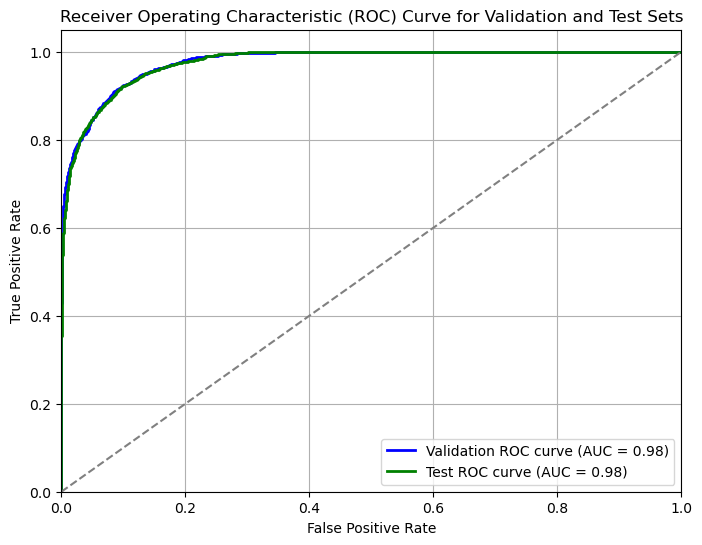

In [56]:
# Step 1: Make predictions for both the validation and test sets
y_val_pred_proba = xgb_clf.predict(dval)  # Get predicted probabilities for validation set
y_test_pred_proba = xgb_clf.predict(dtest)  # Get predicted probabilities for test set

# Step 2: Extract probabilities for the positive class (class 1)
y_val_pred_proba_class1 = y_val_pred_proba  # Probabilities for class 1 (validation set)
y_test_pred_proba_class1 = y_test_pred_proba  # Probabilities for class 1 (test set)

# Step 3: Compute the ROC curve for both datasets
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred_proba_class1)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba_class1)

# Step 4: Calculate the AUC for both validation and test sets
roc_auc_val = auc(fpr_val, tpr_val)
roc_auc_test = auc(fpr_test, tpr_test)

# Step 5: Plot both ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_val, tpr_val, color='blue', lw=2, label=f'Validation ROC curve (AUC = {roc_auc_val:.2f})')
plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')

# Plot the diagonal line (representing random classifier with AUC = 0.5)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Add labels, title, and legend
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Validation and Test Sets')
plt.legend(loc='lower right')
plt.grid(True)

# Show the plot
plt.show()

In [57]:
# Make predictions
y_test_pred_prob = xgb_clf.predict(dtest)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Calculate F1 score (after converting probabilities to labels)
final_f1 = f1_score(y_test, y_test_pred, average='weighted')
print(f"Final F1 score on test set: {final_f1}")

Final F1 score on test set: 0.9293422137348395


## 11. Selecting the final model

In [58]:
model = xgb_clf

In [59]:
import pickle
output_file = 'model.bin'
output_file

'model.bin'

In [60]:
with open(output_file, 'wb') as f_out: 
    pickle.dump((dv, model), f_out)

In [61]:
dv, model

(DictVectorizer(sparse=False), <xgboost.core.Booster at 0x11c4de30df0>)

## 12. Loading the model

In [72]:
input_file = 'model.bin'

In [73]:
with open(input_file, 'rb') as f_in: 
    dv, model = pickle.load(f_in)

In [74]:
!pip freeze > requirements.txt

In [82]:
# Customer data (the input data you want to predict for)
customer = {
    "person_age": 26.0, 
    "person_gender": "F", 
    "person_education": "Master", 
    "person_income": 99999.0, 
    "person_emp_exp": 10, 
    "person_home_ownership": "MORTGAGE", 
    "loan_amnt": 25000.0, 
    "loan_intent": "EDUCATION", 
    "loan_int_rate": 15.77, 
    "loan_percent_income": 0.15, 
    "cb_person_cred_hist_length": 3.0, 
    "credit_score": 584, 
    "previous_loan_defaults_on_file": "No"
}


In [83]:
# Process the customer's data
customer_dict = [customer]  # Needs to be a list of dictionaries
customer_transformed = dv.transform(customer_dict)

#Create a DMatrix
customer_dmatrix = xgb.DMatrix(customer_transformed, feature_names=features)

# Predict the probability of churn
customer_prediction = xgb_clf.predict(customer_dmatrix)

print("Probability that this customer will get loan:", customer_prediction[0])


Probability that this customer will get loan: 0.6623308


In [84]:
# Convert the probability into a binary classification
threshold = 0.5
customer_class = 1 if customer_prediction[0] >= threshold else 0

print("Predicted class (1 = approved; 0 = rejected):", customer_class)


Predicted class (1 = approved; 0 = rejected): 1
